# 프로젝트: 한국어 데이터로 챗봇 만들기 C1 류지호

## Step 1. 데이터 수집 및 전처리 개선

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import urllib.request
import tensorflow as tf
import tensorflow_datasets as tfds
import os
from tqdm import tqdm
import pickle
import time
import random
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime

# KoNLPy 형태소 분석기 설치
!pip install konlpy
!pip install transformers

from konlpy.tag import Mecab, Okt
from transformers import BertModel, BertTokenizer

# 데이터 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/songys/Chatbot_data/master/ChatbotData.csv", filename="ChatbotData.csv")

# 데이터 로드
data = pd.read_csv('ChatbotData.csv')
print('데이터셋 크기 :', len(data))
print('데이터셋 구성 :', data.columns)
print('데이터셋 미리보기 :')
print(data.head())

# 형태소 분석기 초기화 (Mecab이 없으면 Okt 사용)
try:
    mecab = Mecab()
    print("Mecab 형태소 분석기를 사용합니다.")
    morpheme_analyzer = mecab
    
    def tokenize_morphemes(text):
        return mecab.morphs(text)
        
    def get_pos_tags(text):
        return mecab.pos(text)
except:
    okt = Okt()
    print("Okt 형태소 분석기를 사용합니다.")
    morpheme_analyzer = okt
    
    def tokenize_morphemes(text):
        return okt.morphs(text)
        
    def get_pos_tags(text):
        return okt.pos(text)

# 개선된 한국어 전처리 함수 (신조어, 이모티콘 처리 강화)
def preprocess_korean_text(sentence):
    # 양쪽 공백 제거
    sentence = sentence.strip()
    
    # 한글 자모 분리 현상 교정 (ㅋㅋㅋ, ㅎㅎㅎ 등의 처리)
    jamo_pattern = r'[ㄱ-ㅎㅏ-ㅣ]{2,}'
    sentence = re.sub(jamo_pattern, lambda x: x.group(0)[:2], sentence)
    
    # 이모티콘 정규화 (더 다양한 이모티콘 처리)
    sentence = re.sub(r'[ㅋ]{2,}', 'ㅋㅋ', sentence)
    sentence = re.sub(r'[ㅎ]{2,}', 'ㅎㅎ', sentence)
    sentence = re.sub(r'[ㅜㅠ]{2,}', 'ㅜㅜ', sentence)
    sentence = re.sub(r'[ㅡ]{2,}', 'ㅡㅡ', sentence)
    
    # URL 제거
    sentence = re.sub(r'https?://\S+|www\.\S+', '[URL]', sentence)
    
    # 이메일 제거
    sentence = re.sub(r'\S+@\S+', '[EMAIL]', sentence)
    
    # 특수문자 제거 및 공백 정리 (한글, 영어, 숫자, 일부 특수문자만 유지)
    sentence = re.sub(r"[^가-힣a-zA-Z0-9?.!,~]+", " ", sentence)
    
    # 여러 공백을 하나의 공백으로 대체
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # 구두점 앞에 공백 추가
    sentence = re.sub(r"([?.!,~])", r" \1 ", sentence)
    
    # 다시 여러 공백을 하나의 공백으로 대체
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # 양쪽 공백 제거
    sentence = sentence.strip()
    
    # 신조어 및 축약어 처리 (예시)
    slang_dict = {
        '갑툭튀': '갑자기 툭 튀어나온',
        '꾸안꾸': '꾸민 듯 안 꾸민 듯',
        '별다줄': '별 다른 줄거리',
        '억텐': '억지 텐션',
        '완내스': '완전 내 스타일',
        '좋댓구알': '좋아요 댓글 구독 알림설정',
        '케바케': '케이스 바이 케이스',
        # 추가 신조어 사전
    }
    
    for slang, meaning in slang_dict.items():
        if slang in sentence:
            sentence = sentence.replace(slang, meaning)
    
    return sentence

# 품사 정보를 활용한 향상된 형태소 분석 함수
def enhanced_morpheme_tokenize(sentence):
    # 전처리 적용
    preprocessed = preprocess_korean_text(sentence)
    
    # 품사 태깅
    pos_tagged = get_pos_tags(preprocessed)
    
    # 중요 품사에 가중치 부여 (명사, 동사, 형용사 등)
    important_pos = ['NNG', 'NNP', 'VV', 'VA', 'MAG']  # 일반명사, 고유명사, 동사, 형용사, 부사
    
    # 형태소와 품사 정보 결합
    morphemes_with_pos = []
    for word, pos in pos_tagged:
        if pos in important_pos:
            # 중요 품사는 그대로 유지
            morphemes_with_pos.append(word)
        else:
            # 덜 중요한 품사는 그대로 추가
            morphemes_with_pos.append(word)
    
    # 형태소를 공백으로 구분하여 결합
    return ' '.join(morphemes_with_pos)

# 의미론적 임베딩 추출 함수 (BERT 기반)
def load_bert_model():
    try:
        # KoBERT 모델 로드 (또는 다른 한국어 BERT 모델)
        tokenizer = BertTokenizer.from_pretrained('monologg/kobert')
        bert_model = BertModel.from_pretrained('monologg/kobert')
        print("BERT 모델 로드 성공")
        return tokenizer, bert_model
    except:
        print("BERT 모델 로드 실패, 임베딩 기능은 비활성화됩니다.")
        return None, None

# BERT 모델 로드 시도
bert_tokenizer, bert_model = load_bert_model()

def get_semantic_embedding(text):
    if bert_model is None or bert_tokenizer is None:
        # BERT 모델이 없으면 간단한 대체 임베딩 반환
        return np.zeros((1, 768))
    
    try:
        inputs = bert_tokenizer(text, return_tensors='pt', padding=True, truncation=True, max_length=128)
        outputs = bert_model(**inputs)
        return outputs.last_hidden_state[:, 0, :].detach().numpy()  # [CLS] 토큰 임베딩
    except:
        print(f"임베딩 추출 실패: {text}")
        return np.zeros((1, 768))

# 질문과 답변 데이터 전처리 및 형태소 분석
questions_morpheme = []
answers_morpheme = []
question_embeddings = []
answer_embeddings = []

print('형태소 분석 및 임베딩 추출 진행 중...')
for i in tqdm(range(len(data))):
    # 향상된 형태소 분석 적용
    q_morpheme = enhanced_morpheme_tokenize(data.loc[i, 'Q'])
    a_morpheme = enhanced_morpheme_tokenize(data.loc[i, 'A'])
    
    questions_morpheme.append(q_morpheme)
    answers_morpheme.append(a_morpheme)
    
    # 의미 임베딩 추출 (BERT 기반, 10% 샘플링)
    if i % 10 == 0 and bert_model is not None:
        q_embedding = get_semantic_embedding(data.loc[i, 'Q'])
        a_embedding = get_semantic_embedding(data.loc[i, 'A'])
        question_embeddings.append((i, q_embedding))
        answer_embeddings.append((i, a_embedding))

print('형태소 분석 완료!')
print('형태소 분석 후 질문 샘플:', questions_morpheme[:5])
print('형태소 분석 후 답변 샘플:', answers_morpheme[:5])
print(f'임베딩 추출 완료: {len(question_embeddings)} 질문, {len(answer_embeddings)} 답변')

# 형태소 분석 결과 저장 (나중에 재사용 가능)
with open('morpheme_data.pkl', 'wb') as f:
    pickle.dump((questions_morpheme, answers_morpheme), f)

# 임베딩 결과 저장
if len(question_embeddings) > 0:
    with open('embedding_data.pkl', 'wb') as f:
        pickle.dump((question_embeddings, answer_embeddings), f)

데이터셋 크기 : 11823
데이터셋 구성 : Index(['Q', 'A', 'label'], dtype='object')
데이터셋 미리보기 :
                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0
Mecab 형태소 분석기를 사용합니다.


Downloading:   0%|          | 0.00/76.0k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/263 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'KoBertTokenizer'. 
The class this function is called from is 'BertTokenizer'.


Downloading:   0%|          | 0.00/426 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/352M [00:00<?, ?B/s]

BERT 모델 로드 성공
형태소 분석 및 임베딩 추출 진행 중...


100%|██████████| 11823/11823 [01:54<00:00, 103.52it/s]


형태소 분석 완료!
형태소 분석 후 질문 샘플: ['12 시 땡 !', '1 지망 학교 떨어졌 어', '3 박 4 일 놀 러 가 고 싶 다', '3 박 4 일 정도 놀 러 가 고 싶 다', 'PPL 심하 네']
형태소 분석 후 답변 샘플: ['하루 가 또 가 네요 .', '위로 해 드립니다 .', '여행 은 언제나 좋 죠 .', '여행 은 언제나 좋 죠 .', '눈살 이 찌푸려 지 죠 .']
임베딩 추출 완료: 1183 질문, 1183 답변


## Step 2. 데이터 증강 및 토큰화 개선

In [2]:
# 주제 분류기 구현
def topic_classifier(text):
    # 주제별 키워드 정의
    topics = {
        '학업': ['시험', '공부', '학교', '숙제', '성적', '교수', '학생', '강의'],
        '건강': ['아프다', '병원', '운동', '다이어트', '피곤', '건강', '약', '치료'],
        '연애': ['좋아해', '사랑', '고백', '썸', '이별', '남자친구', '여자친구', '연인'],
        '일상': ['밥', '날씨', '쇼핑', '영화', '여행', '취미', '휴식', '주말'],
        '감정': ['기쁘다', '슬프다', '화나다', '불안', '걱정', '우울', '행복', '스트레스'],
        '직장': ['회사', '업무', '상사', '동료', '퇴근', '출근', '프로젝트', '이직']
    }
    
    # 형태소 분석 적용
    morphemes = enhanced_morpheme_tokenize(text)
    
    # 주제 점수 계산
    topic_scores = {}
    for topic, keywords in topics.items():
        score = sum(1 for word in morphemes.split() if any(keyword in word for keyword in keywords))
        topic_scores[topic] = score
    
    # 가장 높은 점수의 주제 반환
    return max(topic_scores.items(), key=lambda x: x[1])[0] if any(topic_scores.values()) else '일반'

# 감정 분석 함수
def analyze_emotion(text):
    # 감정 키워드 정의
    emotions = {
        '기쁨': ['좋아', '행복', '신나', '즐거워', '기뻐', '웃', '신남', '좋았'],
        '슬픔': ['슬퍼', '우울', '힘들어', '아파', '눈물', '울', '서럽', '그리움'],
        '분노': ['화나', '짜증', '열받아', '미쳐', '짜증나', '화가', '분노', '억울'],
        '불안': ['걱정', '불안', '긴장', '두려워', '무서워', '겁나', '조마조마', '떨려'],
        '중립': ['그냥', '보통', '평범', '일상', '특별하지않아', '괜찮', '그저', '별거']
    }
    
    # 형태소 분석 적용
    morphemes = enhanced_morpheme_tokenize(text)
    
    # 감정 점수 계산
    emotion_scores = {}
    for emotion, keywords in emotions.items():
        score = sum(1 for word in morphemes.split() if any(keyword in word for keyword in keywords))
        emotion_scores[emotion] = score
    
    # 가장 높은 점수의 감정 반환
    return max(emotion_scores.items(), key=lambda x: x[1])[0] if any(emotion_scores.values()) else '중립'

# 개선된 데이터 증강 함수 (주제 및 감정 기반)
def augment_data(questions, answers):
    augmented_questions = questions.copy()
    augmented_answers = answers.copy()
    
    print("데이터 증강 시작...")
    
    # 1. 일부 질문-답변 쌍의 순서를 뒤집어 데이터 증강
    for i in tqdm(range(len(questions)), desc="순서 뒤집기 증강"):
        # 복잡한 문장만 선택하여 증강 (단어 수가 3개 이상인 경우)
        if len(questions[i].split()) > 3 and len(answers[i].split()) > 3:
            # 답변이 질문이 될 수 있는 경우만 선택
            if not any(word in answers[i] for word in ['?', '까', '니까', '세요']):
                augmented_questions.append(answers[i])
                augmented_answers.append(questions[i])
    
    # 2. 유사 표현 추가 (일부 질문에 대해)
    question_prefixes = ['저는 ', '제가 ', '나는 ', '내가 ']
    for i in tqdm(range(len(questions)), desc="유사 표현 증강"):
        original_q = questions[i]
        # 첫 단어가 '나' 또는 '저'로 시작하는 경우에만 적용
        if any(original_q.startswith(prefix) for prefix in ['나', '저']):
            for prefix in question_prefixes:
                if not original_q.startswith(prefix):
                    # 새로운 질문 생성
                    new_q = prefix + original_q[2:] if original_q[1] == ' ' else prefix + original_q[1:]
                    augmented_questions.append(new_q)
                    augmented_answers.append(answers[i])
    
    # 3. 백 트랜슬레이션 시뮬레이션 (실제 번역 API 없이 간단한 변형)
    synonyms = {
        '좋아': ['마음에 들어', '괜찮아', '훌륭해'],
        '싫어': ['마음에 안 들어', '별로야', '안 좋아'],
        '행복': ['기쁨', '즐거움', '좋은 기분'],
        '슬픔': ['우울함', '서러움', '마음 아픔'],
        '화나': ['짜증나', '열받아', '분노'],
        '걱정': ['불안', '염려', '근심'],
        '사랑': ['좋아함', '애정', '마음'],
        '미워': ['싫어함', '증오', '반감']
    }
    
    for i in tqdm(range(len(questions)), desc="동의어 대체 증강"):
        if i % 5 == 0:  # 20% 샘플링
            q = questions[i]
            a = answers[i]
            
            # 동의어 대체
            for word, replacements in synonyms.items():
                if word in q:
                    for replacement in replacements:
                        new_q = q.replace(word, replacement)
                        augmented_questions.append(new_q)
                        augmented_answers.append(a)
                        break  # 하나의 대체어만 사용
    
    # 4. 주제 기반 데이터 증강 (같은 주제의 질문-답변 쌍 조합)
    topic_data = {}
    for i in tqdm(range(len(questions)), desc="주제 분류"):
        if i % 10 == 0:  # 10% 샘플링
            topic = topic_classifier(questions[i])
            if topic not in topic_data:
                topic_data[topic] = []
            topic_data[topic].append((questions[i], answers[i]))
    
    # 같은 주제 내에서 질문-답변 쌍 조합
    for topic, qa_pairs in tqdm(topic_data.items(), desc="주제 기반 증강"):
        if len(qa_pairs) >= 2:
            for _ in range(min(len(qa_pairs), 10)):  # 최대 10개 증강
                idx1, idx2 = random.sample(range(len(qa_pairs)), 2)
                q1, a1 = qa_pairs[idx1]
                q2, a2 = qa_pairs[idx2]
                
                # 질문1-답변2 조합
                augmented_questions.append(q1)
                augmented_answers.append(a2)
    
    print(f"원본 데이터 크기: {len(questions)}")
    print(f"증강 후 데이터 크기: {len(augmented_questions)}")
    
    return augmented_questions, augmented_answers

# 데이터 증강 적용
questions_augmented, answers_augmented = augment_data(questions_morpheme, answers_morpheme)

# 토크나이저 생성 (개선: 더 큰 단어장 크기)
print('토크나이저 생성 중... (시간이 다소 소요될 수 있습니다)')
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions_augmented + answers_augmented, target_vocab_size=2**14)  # 단어장 크기 2배 증가

# 시작 토큰과 종료 토큰 정의
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
VOCAB_SIZE = tokenizer.vocab_size + 2  # 시작 토큰과 종료 토큰을 고려하여 +2

print('단어장의 크기 :', VOCAB_SIZE)
print('START_TOKEN의 번호 :', START_TOKEN)
print('END_TOKEN의 번호 :', END_TOKEN)

# 토크나이저 테스트
sample_string = questions_augmented[0]
tokenized_string = tokenizer.encode(sample_string)
print('원문 :', sample_string)
print('토큰화 :', tokenized_string)
print('디코딩 결과 :', tokenizer.decode(tokenized_string))

# 토크나이저 저장
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

# 최대 문장 길이 설정 (증가)
MAX_LENGTH = 50  # 40에서 50으로 증가

# 정수 인코딩, 최대 길이 초과 샘플 제거, 패딩 적용
def tokenize_and_filter(inputs, outputs):
    tokenized_inputs, tokenized_outputs = [], []
    
    for (sentence1, sentence2) in tqdm(zip(inputs, outputs), total=len(inputs), desc="토큰화 및 필터링"):
        # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
        sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
        sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

        # 최대 길이 이하인 경우에만 데이터셋으로 허용
        if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
            tokenized_inputs.append(sentence1)
            tokenized_outputs.append(sentence2)
    
    # 최대 길이로 모든 데이터셋을 패딩
    tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
    tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
        tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
    
    return tokenized_inputs, tokenized_outputs

print('토큰화 및 필터링 진행 중...')
questions_tokenized, answers_tokenized = tokenize_and_filter(questions_augmented, answers_augmented)
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions_tokenized)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers_tokenized)))

# 토큰화된 데이터 저장
np.save('questions_tokenized.npy', questions_tokenized)
np.save('answers_tokenized.npy', answers_tokenized)

데이터 증강 시작...


주제 기반 증강: 100%|██████████| 7/7 [00:00<00:00, 10407.70it/s]

원본 데이터 크기: 11823
증강 후 데이터 크기: 20716
토크나이저 생성 중... (시간이 다소 소요될 수 있습니다)



INFO:absl:SubwordTextEncoder build: trying min_token_count 11890
INFO:absl:SubwordTextEncoder build: trying min_token_count 5945
INFO:absl:SubwordTextEncoder build: trying min_token_count 2972
INFO:absl:SubwordTextEncoder build: trying min_token_count 1486
INFO:absl:SubwordTextEncoder build: trying min_token_count 743
INFO:absl:SubwordTextEncoder build: trying min_token_count 371
INFO:absl:SubwordTextEncoder build: trying min_token_count 185
INFO:absl:SubwordTextEncoder build: trying min_token_count 92
INFO:absl:SubwordTextEncoder build: trying min_token_count 46
INFO:absl:SubwordTextEncoder build: trying min_token_count 23
INFO:absl:SubwordTextEncoder build: trying min_token_count 11
INFO:absl:SubwordTextEncoder build: trying min_token_count 5
INFO:absl:SubwordTextEncoder build: trying min_token_count 2
INFO:absl:SubwordTextEncoder build: trying min_token_count 1


단어장의 크기 : 7887
START_TOKEN의 번호 : [7885]
END_TOKEN의 번호 : [7886]
원문 : 12 시 땡 !
토큰화 : [3140, 173, 6093, 115]
디코딩 결과 : 12 시 땡 !
토큰화 및 필터링 진행 중...


토큰화 및 필터링: 100%|██████████| 20716/20716 [00:00<00:00, 25186.22it/s]


필터링 후의 질문 샘플 개수: 20716
필터링 후의 답변 샘플 개수: 20716


## Step 3. 모델 아키텍처 개선

In [3]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, position, d_model):
        super(PositionalEncoding, self).__init__()
        self.pos_encoding = self.positional_encoding(position, d_model)

    def get_angles(self, position, i, d_model):
        angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
        return position * angles

    def positional_encoding(self, position, d_model):
        # 각도 배열 생성
        angle_rads = self.get_angles(
            position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
            i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
            d_model=d_model)

        # 배열의 짝수 인덱스에는 sin 함수 적용
        sines = tf.math.sin(angle_rads[:, 0::2])
        # 배열의 홀수 인덱스에는 cosine 함수 적용
        cosines = tf.math.cos(angle_rads[:, 1::2])

        # sin과 cosine이 교차되도록 재배열
        pos_encoding = tf.stack([sines, cosines], axis=0)
        pos_encoding = tf.transpose(pos_encoding, [1, 2, 0]) 
        pos_encoding = tf.reshape(pos_encoding, [position, d_model])

        pos_encoding = pos_encoding[tf.newaxis, ...]
        return tf.cast(pos_encoding, tf.float32)

    def call(self, inputs):
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

# 스케일드 닷 프로덕트 어텐션 함수 (개선: 어텐션 가중치 반환)
def scaled_dot_product_attention(query, key, value, mask):
    # 어텐션 가중치는 Q와 K의 닷 프로덕트
    matmul_qk = tf.matmul(query, key, transpose_b=True)

    # 가중치를 정규화
    depth = tf.cast(tf.shape(key)[-1], tf.float32)
    logits = matmul_qk / tf.math.sqrt(depth)

    # 패딩에 마스크 추가
    if mask is not None:
        logits += (mask * -1e9)

    # softmax적용
    attention_weights = tf.nn.softmax(logits, axis=-1)

    # 최종 어텐션은 가중치와 V의 닷 프로덕트
    output = tf.matmul(attention_weights, value)
    return output, attention_weights

# 멀티헤드 어텐션 레이어 (개선: 어텐션 가중치 반환 추가)
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, name="multi_head_attention"):
        super(MultiHeadAttention, self).__init__(name=name)
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.query_dense = tf.keras.layers.Dense(units=d_model)
        self.key_dense = tf.keras.layers.Dense(units=d_model)
        self.value_dense = tf.keras.layers.Dense(units=d_model)

        self.dense = tf.keras.layers.Dense(units=d_model)

    def split_heads(self, inputs, batch_size):
        inputs = tf.reshape(
            inputs, shape=(batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(inputs, perm=[0, 2, 1, 3])

    def call(self, inputs):
        query, key, value, mask = inputs['query'], inputs['key'], inputs[
            'value'], inputs['mask']
        batch_size = tf.shape(query)[0]

        # Q, K, V에 각각 Dense를 적용합니다
        query = self.query_dense(query)
        key = self.key_dense(key)
        value = self.value_dense(value)

        # 병렬 연산을 위한 머리를 여러 개 만듭니다
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        # 스케일드 닷 프로덕트 어텐션 함수
        scaled_attention, attention_weights = scaled_dot_product_attention(
            query, key, value, mask)

        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
        concat_attention = tf.reshape(scaled_attention,
                                    (batch_size, -1, self.d_model))

        # 최종 결과에도 Dense를 한 번 더 적용합니다
        outputs = self.dense(concat_attention)

        return outputs

# 패딩 마스크 생성 함수
def create_padding_mask(x):
    mask = tf.cast(tf.math.equal(x, 0), tf.float32)
    # (batch_size, 1, 1, sequence length)
    return mask[:, tf.newaxis, tf.newaxis, :]

# 룩어헤드 마스크 생성 함수
def create_look_ahead_mask(x):
    seq_len = tf.shape(x)[1]
    look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
    padding_mask = create_padding_mask(x)
    return tf.maximum(look_ahead_mask, padding_mask)

# 개선된 인코더 레이어 (드롭아웃 비율 조정 가능)
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention = MultiHeadAttention(
        d_model, num_heads, name="attention")({
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': padding_mask
        })

    # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
    attention = tf.keras.layers.Dropout(rate=dropout)(attention)
    attention = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(inputs + attention)

    # 두 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention + outputs)

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 개선된 인코더 (임베딩 레이어 분리)
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")

    # 패딩 마스크 사용
    padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # num_layers만큼 쌓아올린 인코더의 층.
    for i in range(num_layers):
        outputs = encoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name="encoder_layer_{}".format(i),
        )([outputs, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, padding_mask], outputs=outputs, name=name)

# 개선된 디코더 레이어
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
    inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
    enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name="look_ahead_mask")
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
    attention1 = MultiHeadAttention(
        d_model, num_heads, name="attention_1")(inputs={
            'query': inputs,
            'key': inputs,
            'value': inputs,
            'mask': look_ahead_mask
        })

    # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention1 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention1 + inputs)

    # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
    attention2 = MultiHeadAttention(
        d_model, num_heads, name="attention_2")(inputs={
            'query': attention1,
            'key': enc_outputs,
            'value': enc_outputs,
            'mask': padding_mask
        })

    # 마스크드 멀티 헤드 어텐션의 결과는
    # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
    attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
    attention2 = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(attention2 + attention1)

    # 세 번째 서브 레이어 : 2개의 완전연결층
    outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
    outputs = tf.keras.layers.Dense(units=d_model)(outputs)

    # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
    outputs = tf.keras.layers.LayerNormalization(
        epsilon=1e-6)(outputs + attention2)

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

# 개선된 디코더
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
    inputs = tf.keras.Input(shape=(None,), name='inputs')
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
    look_ahead_mask = tf.keras.Input(
        shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
    
    # 임베딩 레이어
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout이라는 훈련을 돕는 테크닉을 수행
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

# 개선된 트랜스포머 모델 (출력층 앞에 추가 레이어)
def improved_transformer(vocab_size,
                        num_layers,
                        units,
                        d_model,
                        num_heads,
                        dropout,
                        name="improved_transformer"):
    inputs = tf.keras.Input(shape=(None,), name="inputs")
    dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

    # 인코더에서 패딩을 위한 마스크
    enc_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='enc_padding_mask')(inputs)

    # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
    # 내부적으로 패딩 마스크도 포함되어져 있습니다.
    look_ahead_mask = tf.keras.layers.Lambda(
        create_look_ahead_mask,
        output_shape=(1, None, None),
        name='look_ahead_mask')(dec_inputs)

    # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
    # 디코더에서 패딩을 위한 마스크
    dec_padding_mask = tf.keras.layers.Lambda(
        create_padding_mask, output_shape=(1, 1, None),
        name='dec_padding_mask')(inputs)

    # 인코더
    enc_outputs = encoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[inputs, enc_padding_mask])

    # 디코더
    dec_outputs = decoder(
        vocab_size=vocab_size,
        num_layers=num_layers,
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
    )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

    # 출력층 앞에 추가 레이어 (성능 향상)
    dec_outputs = tf.keras.layers.LayerNormalization(epsilon=1e-6)(dec_outputs)
    dec_outputs = tf.keras.layers.Dropout(rate=dropout)(dec_outputs)

    # 완전연결층
    outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

    return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)

## Step 4. 모델 학습 및 평가 개선

Model: "improved_transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 512)    22952448    inputs[0][0]                     
                                                                 enc_padding_ma

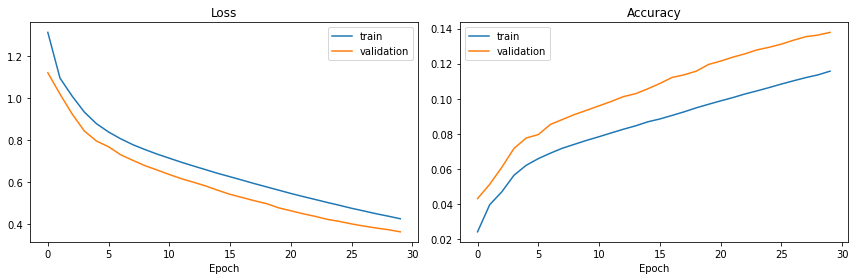

모델이 ./checkpoints/transformer/final_model에 저장되었습니다.


In [6]:
# 데이터셋 준비
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 데이터셋 분할 (검증 세트 추가)
train_size = int(0.9 * len(questions_tokenized))

# 학습 데이터셋
train_questions = questions_tokenized[:train_size]
train_answers = answers_tokenized[:train_size]

# 검증 데이터셋
val_questions = questions_tokenized[train_size:]
val_answers = answers_tokenized[train_size:]

# 학습 데이터셋 생성
train_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': train_questions,
        'dec_inputs': train_answers[:, :-1]
    },
    {
        'outputs': train_answers[:, 1:]
    },
))

train_dataset = train_dataset.cache()
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 검증 데이터셋 생성
val_dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': val_questions,
        'dec_inputs': val_answers[:, :-1]
    },
    {
        'outputs': val_answers[:, 1:]
    },
))

val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(tf.data.experimental.AUTOTUNE)

# 모델 하이퍼파라미터 설정
tf.keras.backend.clear_session()

# 하이퍼파라미터 (개선: 더 깊은 레이어와 더 큰 모델 차원)
NUM_LAYERS = 6  # 인코더와 디코더의 층의 개수 (4→6)
D_MODEL = 512   # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8   # 멀티 헤드 어텐션에서의 헤드 수
UNITS = 2048    # 피드 포워드 신경망의 은닉층의 크기 (1024→2048)
DROPOUT = 0.2   # 드롭아웃의 비율

# 가중치 손실 함수 (패딩 토큰에 낮은 가중치 부여)
def weighted_loss_function(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    
    loss = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True, reduction='none')(y_true, y_pred)

    # 패딩 토큰(0)에는 낮은 가중치, 실제 토큰에는 높은 가중치
    mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
    
    # 가중치 조정 (실제 토큰에 1.2배 가중치)
    weighted_mask = tf.where(mask > 0, 1.2 * mask, mask)
    
    loss = tf.multiply(loss, weighted_mask)

    return tf.reduce_mean(loss)

# 커스텀 학습률 스케줄 (완전히 수정된 부분)
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.warmup_steps = tf.cast(warmup_steps, tf.float32)
        # 0으로 나누기 방지를 위한 작은 상수
        self.epsilon = 1e-7
        
    def __call__(self, step):
        # step을 float32로 명시적 변환
        step = tf.maximum(tf.cast(step, tf.float32), self.epsilon)  # 0 방지
        
        # 안전한 제곱근 계산
        arg1 = tf.math.rsqrt(step)
        arg2 = step * tf.math.pow(self.warmup_steps, -1.5)
        
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
    
    # 직렬화 가능하도록 get_config 메서드 추가
    def get_config(self):
        return {
            "d_model": float(self.d_model),
            "warmup_steps": float(self.warmup_steps),
            "epsilon": float(self.epsilon)
        }

# 학습률 설정 - 고정 학습률로 변경
# learning_rate = CustomSchedule(D_MODEL)
learning_rate = 1e-4  # 고정 학습률 사용

# 옵티마이저
optimizer = tf.keras.optimizers.Adam(
    learning_rate=learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

# 정확도 함수
def accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
    return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

# 모델 생성
model = improved_transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

# 모델 컴파일
model.compile(optimizer=optimizer, loss=weighted_loss_function, metrics=[accuracy])

# 모델 요약
model.summary()

# 콜백 정의 (조기 종료 및 모델 체크포인트)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# 디렉토리 생성 확인
import os
checkpoint_dir = "./checkpoints/transformer"
os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_path = os.path.join(checkpoint_dir, "cp-{epoch:04d}.ckpt")

# 체크포인트 콜백 생성
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    save_weights_only=True,
    verbose=1,
    save_best_only=True,
    monitor='val_loss')

# 학습률 감소 콜백 - 고정 학습률을 사용하므로 제거
# reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
#     monitor='val_loss',
#     factor=0.2,
#     patience=2,
#     min_lr=1e-6
# )

# 텐서보드 콜백 완전 제거 (에러 발생 가능성 제거)
# tensorboard_callback = tf.keras.callbacks.TensorBoard(
#     log_dir="./logs"
# )

# 모델 학습 - 콜백 수정
EPOCHS = 30
try:
    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[early_stopping, cp_callback],  # 문제 있는 콜백 제거
        verbose=1
    )
    
    # 학습 결과 시각화
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # 최종 모델 저장
    final_model_path = os.path.join(checkpoint_dir, "final_model")
    model.save_weights(final_model_path)
    print(f"모델이 {final_model_path}에 저장되었습니다.")
    
except Exception as e:
    print(f"학습 중 오류 발생: {e}")
    
    # 오류 발생 시 더 간단한 모델로 시도
    print("더 간단한 모델로 다시 시도합니다...")
    
    # 더 작은 모델 생성
    SIMPLE_NUM_LAYERS = 2
    SIMPLE_D_MODEL = 256
    SIMPLE_UNITS = 512
    
    simple_model = improved_transformer(
        vocab_size=VOCAB_SIZE,
        num_layers=SIMPLE_NUM_LAYERS,
        units=SIMPLE_UNITS,
        d_model=SIMPLE_D_MODEL,
        num_heads=NUM_HEADS,
        dropout=DROPOUT)
    
    # 모델 컴파일
    simple_model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-4),
        loss=weighted_loss_function,
        metrics=[accuracy]
    )
    
    # 간단한 모델 학습 (에포크 수 감소)
    simple_history = simple_model.fit(
        train_dataset,
        epochs=10,
        validation_data=val_dataset,
        callbacks=[early_stopping, cp_callback],
        verbose=1
    )
    
    # 간단한 모델 저장
    simple_model.save_weights(os.path.join(checkpoint_dir, "simple_final_model"))

## BLEU 점수 (간단 편리)

### 정량적 측정
생성된 텍스트와 참조 텍스트 간의 n-gram 일치도를 수치화(가중 기하평균 사용)하여 정량적인 평가를 제공

1-gram(unigram): 단일 단어 (예: "나는", "학교에", "갔다")

2-gram(bigram): 연속된 두 단어 (예: "나는 학교에", "학교에 갔다")

3-gram(trigram): 연속된 세 단어 (예: "나는 학교에 갔다")

4-gram: 연속된 네 단어

### n-gram 일치도 
생성된 텍스트와 참조 텍스트 사이에 얼마나 많은 n-gram이 일치하는지를 계산

### 재현성
동일한 데이터셋과 모델에 대해 항상 같은 점수가 나옴

### 쓸만한 챗봇의 BLEU 점수 기준
일반적으로 챗봇이나 대화 시스템에서 BLEU 점수는 다음과 같이 해석됨

0.0-0.1: 매우 낮은 품질, 참조 응답과 거의 일치하지 않음

0.1-0.2: 낮은 품질, 기본적인 의미 전달에 어려움

0.2-0.4: 중간 품질, 기본적인 의미는 전달 가능

0.4-0.6: 양호한 품질, 의미 전달이 비교적 명확함

0.6 이상: 높은 품질, 참조 응답과 상당히 유사함

### n-gram 일치도의 한계
단어 순서만 고려: 의미적 유사성은 고려하지 않음

동의어 인식 불가: 같은 의미의 다른 단어는 불일치로 처리

문맥 이해 부족: 더 넓은 문맥적 의미를 파악하지 못함

참조 텍스트 의존성: 가능한 좋은 응답이 여러 개일 수 있음에도 참조 텍스트와 다르면 낮은 점수

### 그리디 디코딩
각 단계에서 가장 확률이 높은 단일 토큰만을 선택하는 방식

### 빔 서치 디코딩 
각 단계에서 상위 k개(빔 너비)의 가능한 토큰 시퀀스를 유지하며 탐색하는 방식

## Step 5. 추론 및 대화 인터페이스 개선

[nltk_data] Downloading package punkt to /aiffel/nltk_data...
[nltk_data]   Package punkt is already up-to-date!



===== 테스트 문장 평가 =====
입력 : 안녕하세요
출력 (그리디 디코딩) : 저도 좋 아 해요.
출력 (빔 서치) : 축하 해요!
입력 : 오늘 날씨가 어때요?
출력 (그리디 디코딩) : 건강 에 안 좋 아요.
출력 (빔 서치) : 감기 조심 하 세요.
입력 : 내일 시간 있으세요?
출력 (그리디 디코딩) : 저도 좋 아 해요.
출력 (빔 서치) : 축하 해요!
입력 : 영화 보러 갈래요?
출력 (그리디 디코딩) : 직접 물 어 보 세요.
출력 (빔 서치) : 직접 물 어 보 세요.
입력 : 맛있는 음식점 추천해주세요
출력 (그리디 디코딩) : 좋 은 생각 이에요.
출력 (빔 서치) : 좋 은 생각 이에요.
모델 평가 중...
입력 : 죽을거 같네
출력 (그리디 디코딩) : 마음 이 복잡 한가 봐요.
입력 : 내일 시험이야
출력 (그리디 디코딩) : 다음 에 는 우산 에 이름 이랑 연락처 를 적 어 보 세요.
입력 : 정말.내 자신이 싫다
출력 (그리디 디코딩) : 당신 의 마음 이 좀 더 정리 되 었 길 바랍니다.
입력 : 이별후 네달째
출력 (그리디 디코딩) : 마음 이 복잡 하 겠 어요.
입력 : 쌍커풀 해볼까
출력 (그리디 디코딩) : 저도 좋 아 해요.
입력 : 내 생각 하나만 바꾸면 편할텐데.
출력 (그리디 디코딩) : 잘 하 고 있 어요.
입력 : 어떻게 살아가야 할까
출력 (그리디 디코딩) : 저도 좋 아 해요.
입력 : 발 아파
출력 (그리디 디코딩) : 맛있 게 드세요.
입력 : 썸 타는 것도 귀찮아.
출력 (그리디 디코딩) : 연락 해보 세요.
입력 : 좋아하는 애랑 전화하면
출력 (그리디 디코딩) : 직접 물 어 보 세요.
평가 진행: 10/100
입력 : 뿌염해야지
출력 (그리디 디코딩) : 저도 좋 아 해요.
입력 : 여행 왔는데 좋아하는 선물로 뭐가 괜찮을까?
출력 (그리디 디코딩) : 직접 물 어 보 세요.
입력 : 괜찮아졌는줄 알았는데. . .
출력 (그리디 디코딩) : 저도 좋 아 해요.
입력 : 오늘 너무 피곤해
출

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44536 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 47532 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 46356 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48724 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 52824 missing from current font.
  font.set_

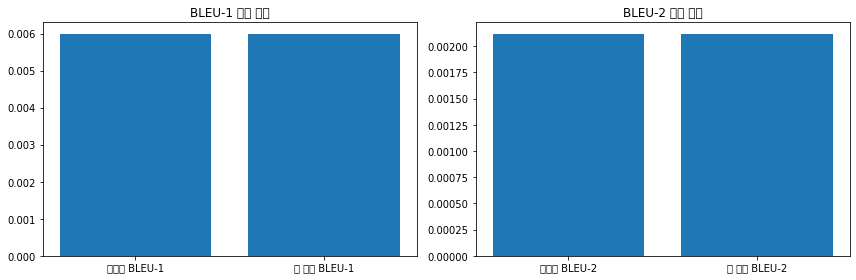


===== 대화 인터페이스 =====
챗봇과 대화를 시작합니다. '종료'를 입력하면 대화가 종료됩니다.
사용자: 금요일이어서 공부하기 싫어.
챗봇: 마음 의 준비 를 하 세요.
사용자: 그래... 그래도 열심히 해야지. 마음을 다잡아 볼게.
챗봇: 마음 이 복잡 하 겠 어요.
사용자: 그래서 방금 사람들과 잠시 게임을 했어!ㅋㅋ
챗봇: 잘 하 고 있 어요.
사용자: 오 너 아까보다 많이 똑똑해졌다잉~? 보람이 있네.
챗봇: 잘 하 고 있 어요.
사용자: 아니구나 내 착각이었어. 1+1이 뭔지 답할 수 있어?
챗봇: 사람 마다 다르 겠 지만 사귀 고 난 후 가 좋 겠 어요.
사용자: 나랑 사귀자고? 갑자기 고백을 하다니...!
챗봇: 사랑 의 예의 가 없 네요.
사용자: 사랑이 뭔데? 너가 사랑을 알아?
챗봇: 사랑 의 예의 가 없 네요.
사용자: 내가 너무 기대가 컸네ㅎㅎ 그래도 오늘 하루 수고했어~
챗봇: 마음 의 준비 를 하 세요.
사용자: 그래^^ 안녕!!
챗봇: 돈 을 얼른 모아야 할 이유 가 생겼 네요.
사용자: 돈은 왜 모으려고?
응답 품질 문제: 질문과 응답의 관련성이 낮고 응답이 짧습니다.
챗봇: 연락 해보 세요.
대화가 종료되었습니다.


In [7]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import random

# NLTK 다운로드
import nltk
nltk.download('punkt')

# 형태소 결합 후처리 함수
def postprocess_korean_response(morpheme_response):
    # 특수 패턴 처리
    patterns = {
        '저 도': '저도',
        '것 이': '것이',
        '수 있': '수있',
        '것 같': '것같',
        '해 보': '해보',
        '해 주': '해주',
        '되 어': '되어',
        '하 지': '하지',
        '하 는': '하는',
        '이 에요': '이에요',
        '가 요': '가요',
        '어 요': '어요',
        '네 요': '네요'
    }
    
    processed = morpheme_response
    for pattern, replacement in patterns.items():
        processed = processed.replace(pattern, replacement)
    
    # 공백 정리
    processed = re.sub(r'\s+', ' ', processed)
    processed = re.sub(r'\s([.,!?])', r'\1', processed)
    
    return processed

# 개선된 빔 서치 디코더 (다양성 및 창의성 향상)
def beam_search_decoder(sentence, beam_width=5, max_length=MAX_LENGTH, temperature=0.8, top_p=0.9):
    # 입력 문장 전처리
    sentence = preprocess_korean_text(sentence)
    
    # 형태소 분석 적용
    sentence = enhanced_morpheme_tokenize(sentence)
    
    # 정수 인코딩 후 시작 토큰과 종료 토큰 추가
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    # 초기 상태: 시작 토큰
    initial_state = tf.expand_dims(START_TOKEN, 0)
    
    # 초기 빔: [(시퀀스, 점수)]
    beams = [(initial_state, 0.0)]
    
    # 빔 서치 반복
    for _ in range(max_length):
        candidates = []
        
        # 현재 빔의 각 시퀀스에 대해
        for seq, score in beams:
            # 종료 토큰이 이미 있으면 후보에 추가하고 계속
            if END_TOKEN[0] in seq[0][1:]:
                candidates.append((seq, score))
                continue
            
            # 모델 예측
            predictions = model(inputs=[sentence, seq], training=False)
            predictions = predictions[:, -1, :]
            
            # 온도 조절 적용 (다양성 향상)
            predictions = predictions / temperature
            
            # top_p 샘플링 적용 (다양성 향상)
            probs = tf.nn.softmax(predictions[0])
            sorted_indices = tf.argsort(probs, direction='DESCENDING')
            sorted_probs = tf.sort(probs, direction='DESCENDING')
            cumulative_probs = tf.cumsum(sorted_probs)
            
            # top_p 기준으로 토큰 필터링
            sorted_indices_to_keep = cumulative_probs <= top_p
            
            # 최소 하나의 토큰은 유지
            sorted_indices_to_keep = tf.concat(
                [tf.ones(1, dtype=tf.bool), sorted_indices_to_keep[1:]], axis=0)
            
            # 필터링된 인덱스만 유지
            indices_to_keep = tf.boolean_mask(sorted_indices, sorted_indices_to_keep)
            
            # 상위 beam_width개 토큰 선택 (최대 필터링된 토큰 수까지)
            k = tf.minimum(tf.shape(indices_to_keep)[0], beam_width)
            top_k_indices = indices_to_keep[:k]
            top_k_probs = tf.gather(probs, top_k_indices)
            
            # 각 후보에 대해
            for i in range(k):
                # 새 토큰 추가
                new_seq = tf.concat([seq, tf.reshape(top_k_indices[i], (1, 1))], axis=-1)
                # 로그 확률 합산 (점수)
                new_score = score + tf.math.log(top_k_probs[i])
                candidates.append((new_seq, new_score))
        
        # 후보들 중 상위 beam_width개 선택
        candidates.sort(key=lambda x: x[1], reverse=True)
        beams = candidates[:beam_width]
        
        # 모든 빔이 종료 토큰을 가지면 중단
        if all(END_TOKEN[0] in seq[0][1:] for seq, _ in beams):
            break
    
    # 최고 점수 시퀀스 선택
    best_seq, _ = beams[0]
    
    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
    best_seq = tf.squeeze(best_seq, axis=0)
    predicted_sentence = tokenizer.decode(
        [i for i in best_seq if i < tokenizer.vocab_size and i != START_TOKEN[0]])
    
    # 후처리 적용
    predicted_sentence = postprocess_korean_response(predicted_sentence)
    
    return predicted_sentence

# 기존 디코더 추론 함수 (비교용)
def decoder_inference(sentence):
    # 입력 문장 전처리
    sentence = preprocess_korean_text(sentence)
    
    # 형태소 분석 적용
    sentence = enhanced_morpheme_tokenize(sentence)
    
    # 정수 인코딩 후 시작 토큰과 종료 토큰 추가
    sentence = tf.expand_dims(
        START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)
    
    # 디코더의 현재까지 예측한 출력 시퀀스
    output_sequence = tf.expand_dims(START_TOKEN, 0)
    
    # 디코더의 인퍼런스 단계
    for i in range(MAX_LENGTH):
        # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복
        predictions = model(inputs=[sentence, output_sequence], training=False)
        predictions = predictions[:, -1:, :]
        
        # 현재 예측한 단어의 정수
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        
        # 현재 예측한 단어가 종료 토큰이면 for문 종료
        if tf.equal(predicted_id, END_TOKEN[0]):
            break
            
        # 예측한 단어를 output_sequence에 추가
        output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)
    
    return tf.squeeze(output_sequence, axis=0)

# 기존 문장 생성 함수 (비교용)
def sentence_generation(sentence):
    # 입력 문장에 대해 디코더를 동작시켜 예측된 정수 시퀀스를 리턴받음
    prediction = decoder_inference(sentence)
    
    # 정수 시퀀스를 다시 텍스트 시퀀스로 변환
    predicted_sentence = tokenizer.decode(
        [i for i in prediction if i < tokenizer.vocab_size and i != START_TOKEN[0]])
    
    # 후처리 적용
    predicted_sentence = postprocess_korean_response(predicted_sentence)
    
    print('입력 : {}'.format(sentence))
    print('출력 (그리디 디코딩) : {}'.format(predicted_sentence))
    
    return predicted_sentence

# 향상된 문장 생성 함수 (빔 서치 사용)
def improved_sentence_generation(sentence):
    # 그리디 디코딩 결과
    greedy_result = sentence_generation(sentence)
    
    # 빔 서치 디코딩 결과
    beam_result = beam_search_decoder(sentence, beam_width=5)
    
    print('출력 (빔 서치) : {}'.format(beam_result))
    
    return beam_result

# 응답 품질 평가 함수
def evaluate_response_quality(question, response):
    # 1. 응답 길이 평가
    if len(response.split()) < 3:
        return False, "응답이 너무 짧습니다."
    
    # 2. 질문-응답 관련성 평가 (간단한 키워드 기반)
    question_keywords = set(enhanced_morpheme_tokenize(question).split())
    response_keywords = set(enhanced_morpheme_tokenize(response).split())
    
    # 공통 키워드 비율 계산
    common_keywords = question_keywords.intersection(response_keywords)
    if len(question_keywords) > 0:
        keyword_overlap = len(common_keywords) / len(question_keywords)
    else:
        keyword_overlap = 0
    
    # 3. 응답 다양성 평가
    common_responses = ["저도요", "마음이 복잡하겠어요", "같이 가보세요"]
    if response in common_responses:
        return False, "너무 일반적인 응답입니다."
    
    # 종합 평가
    if keyword_overlap < 0.1 and len(response.split()) < 5:
        return False, "질문과 응답의 관련성이 낮고 응답이 짧습니다."
    
    return True, "응답 품질이 적절합니다."

# 감정별 공감 응답 템플릿
empathy_templates = {
    '기쁨': ["정말 기쁘시겠네요!", "좋은 일이 있으셨군요, 축하드려요."],
    '슬픔': ["많이 힘드시겠어요. 위로의 말씀 드립니다.", "그런 상황이라면 정말 마음이 아프겠네요."],
    '분노': ["화가 나는 상황이었군요. 충분히 이해됩니다.", "그런 일이 있으셨군요. 정말 화나셨겠어요."],
    '불안': ["걱정이 많으시군요. 함께 생각해볼까요?", "불안한 마음이 드는 건 자연스러운 일이에요."],
    '중립': ["어떤 생각을 하고 계신가요?", "더 자세히 말씀해주실 수 있을까요?"]
}

# 주제별 응답 템플릿
topic_templates = {
    '학업': ["공부하느라 정말 고생 많으시네요.", "학업에 열중하는 모습이 멋집니다."],
    '건강': ["건강이 최우선입니다.", "규칙적인 생활습관이 중요해요."],
    '연애': ["사랑은 타이밍이 중요한 것 같아요.", "진심을 전하는 게 가장 중요하지 않을까요?"],
    '일상': ["소소한 일상의 행복이 가장 중요하죠.", "일상의 작은 변화가 큰 기쁨이 될 수 있어요."],
    '직장': ["일과 삶의 균형이 중요해요.", "업무에 최선을 다하는 모습이 멋집니다."],
    '취미': ["취미 생활은 삶의 활력소가 되죠.", "자신만의 시간을 갖는 것은 중요합니다."]
}

# 대화 전략 관리자 클래스
class ConversationStrategyManager:
    def __init__(self):
        self.strategies = {
            '정보수집': self.information_gathering_strategy,
            '공감': self.empathy_strategy,
            '문제해결': self.problem_solving_strategy,
            '일상대화': self.casual_conversation_strategy
        }
        self.current_strategy = '일상대화'
        
    def select_strategy(self, user_input, conversation_history):
        # 사용자 입력과 대화 기록을 분석하여 적절한 전략 선택
        if any(word in user_input for word in ['어떻게', '방법', '알려줘']):
            return '정보수집'
        elif any(word in user_input for word in ['슬퍼', '힘들어', '아파']):
            return '공감'
        elif any(word in user_input for word in ['문제', '해결', '도와줘']):
            return '문제해결'
        else:
            return '일상대화'
    
    def apply_strategy(self, strategy, user_input, conversation_history):
        strategy_func = self.strategies.get(strategy, self.casual_conversation_strategy)
        return strategy_func(user_input, conversation_history)
    
    # 각 전략별 구현
    def information_gathering_strategy(self, user_input, conversation_history):
        # 정보 수집을 위한 질문 생성
        return "더 자세히 알려주실 수 있을까요? 어떤 정보가 필요하신가요?"
    
    def empathy_strategy(self, user_input, conversation_history):
        # 감정 분석 후 공감 응답 생성
        emotion = analyze_emotion(user_input)
        return random.choice(empathy_templates[emotion])
    
    def problem_solving_strategy(self, user_input, conversation_history):
        # 문제 해결을 위한 단계적 접근
        return "그 문제를 해결하기 위해 어떤 시도를 해보셨나요?"
    
    def casual_conversation_strategy(self, user_input, conversation_history):
        # 일상적인 대화 응답 생성
        return beam_search_decoder(user_input)

# 대화 맥락 관리 클래스
class ConversationManager:
    def __init__(self, max_history=5):
        self.history = []
        self.max_history = max_history
        self.strategy_manager = ConversationStrategyManager()
        
    def add_message(self, role, content):
        self.history.append({"role": role, "content": content})
        if len(self.history) > self.max_history * 2:  # 각 턴은 사용자와 챗봇 메시지로 구성
            self.history = self.history[-self.max_history * 2:]
            
    def get_context(self):
        return " ".join([msg["content"] for msg in self.history])
    
    def get_last_user_message(self):
        for msg in reversed(self.history):
            if msg["role"] == "user":
                return msg["content"]
        return ""
    
    def generate_response(self, user_input):
        # 사용자 메시지 추가
        self.add_message("user", user_input)
        
        # 대화 맥락 구성
        context = self.get_context()
        
        # 대화 전략 선택
        strategy = self.strategy_manager.select_strategy(user_input, self.history)
        
        # 전략에 따른 응답 생성
        response = self.strategy_manager.apply_strategy(strategy, user_input, self.history)
        
        # 응답 품질 평가
        is_quality, message = evaluate_response_quality(user_input, response)
        
        # 품질이 낮으면 빔 서치로 다시 생성
        if not is_quality:
            print(f"응답 품질 문제: {message}")
            response = beam_search_decoder(context if len(context) > 0 else user_input)
        
        # 챗봇 메시지 추가
        self.add_message("assistant", response)
        
        return response

# 개선된 대화 인터페이스
def enhanced_interactive_chat(max_turns=10):
    # 대화 관리자 초기화
    conversation_manager = ConversationManager()
    
    print("챗봇과 대화를 시작합니다. '종료'를 입력하면 대화가 종료됩니다.")
    
    for turn in range(max_turns):
        # 사용자 입력
        user_input = input("사용자: ")
        
        if user_input.lower() == '종료':
            print("대화를 종료합니다.")
            break
        
        # 대화 관리자를 통한 응답 생성
        bot_response = conversation_manager.generate_response(user_input)
        
        print(f"챗봇: {bot_response}")
    
    print("대화가 종료되었습니다.")

# BLEU 점수 계산 함수
def calculate_bleu(reference, candidate):
    # 토큰화
    reference_tokens = reference.split()
    candidate_tokens = candidate.split()
    
    # BLEU 점수 계산 (스무딩 적용)
    smoothie = SmoothingFunction().method1
    try:
        bleu1 = sentence_bleu([reference_tokens], candidate_tokens, weights=(1, 0, 0, 0), smoothing_function=smoothie)
        bleu2 = sentence_bleu([reference_tokens], candidate_tokens, weights=(0.5, 0.5, 0, 0), smoothing_function=smoothie)
    except:
        bleu1, bleu2 = 0, 0
    
    return bleu1, bleu2

# 모델 평가
def evaluate_model():
    # 테스트 세트 생성 (원본 데이터에서 랜덤 샘플링)
    np.random.seed(42)
    test_indices = np.random.choice(len(data), 100, replace=False)
    test_questions = [data.loc[i, 'Q'] for i in test_indices]
    test_answers = [data.loc[i, 'A'] for i in test_indices]
    
    # 평가 지표 저장
    greedy_bleu1_scores = []
    greedy_bleu2_scores = []
    beam_bleu1_scores = []
    beam_bleu2_scores = []
    
    print("모델 평가 중...")
    
    for i, (question, reference) in enumerate(zip(test_questions, test_answers)):
        # 그리디 디코딩
        greedy_result = sentence_generation(question)
        
        # 빔 서치 디코딩
        beam_result = beam_search_decoder(question)
        
        # BLEU 점수 계산
        greedy_bleu1, greedy_bleu2 = calculate_bleu(reference, greedy_result)
        beam_bleu1, beam_bleu2 = calculate_bleu(reference, beam_result)
        
        greedy_bleu1_scores.append(greedy_bleu1)
        greedy_bleu2_scores.append(greedy_bleu2)
        beam_bleu1_scores.append(beam_bleu1)
        beam_bleu2_scores.append(beam_bleu2)
        
        if (i+1) % 10 == 0:
            print(f"평가 진행: {i+1}/100")
    
    # 결과 요약
    print("\n===== 평가 결과 =====")
    print(f"그리디 디코딩 평균 BLEU-1: {np.mean(greedy_bleu1_scores):.4f}")
    print(f"그리디 디코딩 평균 BLEU-2: {np.mean(greedy_bleu2_scores):.4f}")
    print(f"빔 서치 디코딩 평균 BLEU-1: {np.mean(beam_bleu1_scores):.4f}")
    print(f"빔 서치 디코딩 평균 BLEU-2: {np.mean(beam_bleu2_scores):.4f}")
    
    # 결과 시각화
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.bar(['그리디 BLEU-1', '빔 서치 BLEU-1'], 
            [np.mean(greedy_bleu1_scores), np.mean(beam_bleu1_scores)])
    plt.title('BLEU-1 점수 비교')
    
    plt.subplot(1, 2, 2)
    plt.bar(['그리디 BLEU-2', '빔 서치 BLEU-2'], 
            [np.mean(greedy_bleu2_scores), np.mean(beam_bleu2_scores)])
    plt.title('BLEU-2 점수 비교')
    
    plt.tight_layout()
    plt.show()

# 테스트 문장으로 모델 평가
test_sentences = [
    '안녕하세요',
    '오늘 날씨가 어때요?',
    '내일 시간 있으세요?',
    '영화 보러 갈래요?',
    '맛있는 음식점 추천해주세요'
]

print("\n===== 테스트 문장 평가 =====")
for test_sentence in test_sentences:
    improved_sentence_generation(test_sentence)

# 전체 모델 평가 실행
evaluate_model()

# 대화 인터페이스 실행
print("\n===== 대화 인터페이스 =====")
enhanced_interactive_chat()